In [1]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from scipy.io.arff import loadarff
import pandas as pd


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Reading Data

In [89]:
df_train = pd.read_csv('training_data')
df_val = pd.read_csv('validation_data')
df_test = pd.read_csv('test_data')
df_anomaly = pd.read_csv('anomaly_data')

In [90]:
df_train = torch.tensor(df_train.values)
df_val = torch.tensor(df_val.values)
df_test = torch.tensor(df_test.values)
df_anomaly = torch.tensor(df_anomaly.values)

In [91]:
# Normalize to 0 - 1
min_val = torch.min(df_train)
max_val = torch.max(df_train)

df_train = (df_train - min_val) / (max_val - min_val)
df_val = (df_val - min_val) / (max_val - min_val)
df_test = (df_test - min_val) / (max_val - min_val)
df_anomaly = (df_anomaly - min_val) / (max_val - min_val)

In [92]:
df_train = pd.DataFrame(df_train).astype("float")
df_val = pd.DataFrame(df_val).astype("float")
df_test = pd.DataFrame(df_test).astype("float")
df_anomaly = pd.DataFrame(df_anomaly).astype("float")


In [93]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [94]:
train_dataset, seq_len, n_features = create_dataset(df_train)
val_dataset, _, _ = create_dataset(df_val)
test_normal_dataset, _, _ = create_dataset(df_test)
test_anomaly_dataset, _, _ = create_dataset(df_anomaly)

Model

In [95]:
# Creating a PyTorch class
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(n_features, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU()
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, n_features),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [96]:
def train_model(n_epochs):
  # Model Initialization
  model = AE()

  # Validation using MSE Loss function
  criterion = nn.L1Loss(reduction='sum').to(device)

  # Using an Adam Optimizer with lr = 0.1
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  #n_epochs = 3
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [133]:
model, history = train_model(n_epochs = 10)

Epoch 1: train loss 6.091654214268615 val loss 0.5698790251315661
Epoch 2: train loss 0.17688929149721455 val loss 0.09629950192693161
Epoch 3: train loss 0.07004402791949037 val loss 0.057228362595994176
Epoch 4: train loss 0.044992370766186854 val loss 0.04252049455325625
Epoch 5: train loss 0.0390218207471317 val loss 0.03922246702304578
Epoch 6: train loss 0.03716704731044002 val loss 0.037291259794032465
Epoch 7: train loss 0.03626863413995904 val loss 0.036170674636789926
Epoch 8: train loss 0.03549471791747937 val loss 0.03447507137696357
Epoch 9: train loss 0.03460000325368131 val loss 0.033950128698866114
Epoch 10: train loss 0.03393581375476051 val loss 0.03389815268740398


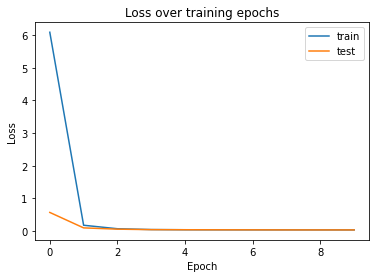

In [134]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

In [143]:
MODEL_PATH = 'model_ae.pth'

torch.save(model, MODEL_PATH)

In [144]:
model = AE()

if torch.cuda.is_available():
    model = torch.load('model_ae.pth')
else:
    model = torch.load('model_ae.pth', map_location=torch.device('cpu'))

model = model.to(device)

In [145]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

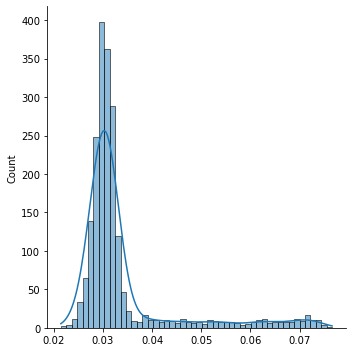

In [146]:
_, losses = predict(model, train_dataset)
sns.displot(losses, bins=50, kde=True)

Choosing Threshold from the above plot which gives maximum correct predictions

In [147]:
THRESHOLD = 0.05

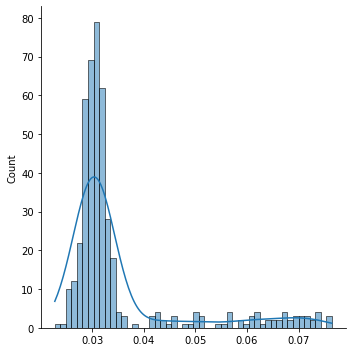

In [148]:
predictions, normal_pred_losses = predict(model, test_normal_dataset)
sns.displot(normal_pred_losses, bins=50, kde=True)

In [149]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

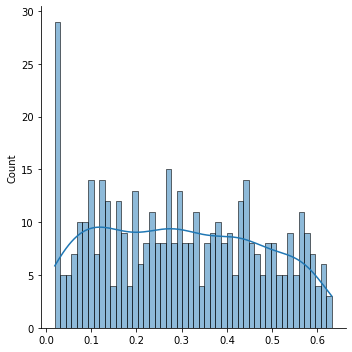

In [150]:
predictions, anomaly_pred_losses = predict(model, anomaly_dataset)
sns.displot(anomaly_pred_losses, bins=50, kde=True)

Performance Metrics

In [151]:
normal_records = len(test_normal_dataset)
anamolous_records = len(anomaly_dataset)
total_test_records = normal_records + anamolous_records

TN = sum(l <= THRESHOLD for l in normal_pred_losses) 
TP = sum(l > THRESHOLD for l in anomaly_pred_losses) 
FP = normal_records - TN
FN = anamolous_records - TP 

Recall = TP/(TP + FN)
Precision  = TP/(TP + FP)
F1_score = (2 * Precision * Recall) / (Precision + Recall)

print("Recall:",Recall)
print("Precision:",Precision)
print("F1 score:",F1_score)

Recall: 0.9178082191780822
Precision: 0.8835164835164835
F1 score: 0.9003359462486001
